<a href="https://colab.research.google.com/github/37stu37/FFE/blob/master/FFE_network_itertuples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%time 
%%capture
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 

CPU times: user 1.28 s, sys: 137 ms, total: 1.42 s
Wall time: 4min 53s


In [2]:
# Load the Drive helper and mount
from google.colab import drive
%tensorflow_version 2.x
# This will prompt for authorization.
drive.mount('/content/drive')

TensorFlow 2.x selected.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%%time
import datetime
import glob
import math
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import networkx as nx
from shapely.geometry import Point
from sys import getsizeof
import dask.dataframe as dd
from dask.distributed import Client
%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

CPU times: user 271 ms, sys: 55.8 ms, total: 327 ms
Wall time: 947 ms


In [0]:
client = Czlient(processes=False)
client

Set up the path  to data and output

In [4]:
path = '/content/drive/My Drive/05_Sync/FFE/FireNetwork/00_input'
path_output = '/content/drive/My Drive/05_Sync/FFE/FireNetwork/00_output'

!ls "/content/drive/My Drive/05_Sync/FFE/FireNetwork/00_input"

buildings_raw.cpg  buildings_raw.prj  buildings_raw.shp  GD_wind.csv
buildings_raw.dbf  buildings_raw.qpj  buildings_raw.shx


Create the functions to be used by the algorithm

In [0]:
def load_data(file_name, minx, miny, maxx, maxy):
    # crop data
    bbox = box(minx, miny, maxx, maxy)
    # building point dataset
    gdf_buildings = gpd.read_file(os.path.join(path, file_name), bbox=bbox)
    print(gdf_buildings.dtypes)
    max_extent = gdf_buildings.total_bounds
    data_size = getsizeof(gdf_buildings)/(1024.0**3)
    print("Shapefile extent : {}".format(max_extent))
    print("Asset loaded : {}".format(len(gdf_buildings)))
    print("Data size:{} GB'".format(data_size))
    # gdf_buildings.IgnProb_bl = 0.02
    # xmin,ymin,xmax,ymax = gdf_buildings.total_bounds
    # Precision of float32 is sufficient for lat and lon
    float_columns = ['SHAPE_Leng','SHAPE_Area',
                    'IgnProb_bl','RandProb']
    gdf_buildings[float_columns] = gdf_buildings[float_columns].astype('float32')
    int_columns = ['TARGET_FID','Combustibl',
                    'AU2013Num','RandProb']
    gdf_buildings[int_columns] = gdf_buildings[int_columns].astype('int32')
    data_size = getsizeof(gdf_buildings)/(1024.0**3)
    print("resized Data size:{} GB'".format(data_size))
    return gdf_buildings


def wind_scenario():
    wind_data = pd.read_csv(os.path.join(path, 'GD_wind.csv'))
    i = np.random.randint(0, wind_data.shape[0])
    w = wind_data.iloc[i, 2]
    d = wind_data.iloc[i, 1]
    b = wind_data.iloc[i, 3]
    return w, d, b


def create_network(edge_list_dataframe):
    graph = nx.from_pandas_edgelist(edge_list_dataframe, edge_attr=True)
    # options = {'node_color': 'red', 'node_size': 50, 'width': 1, 'alpha': 0.4,
    #            'with_labels': False, 'font_weight': 'bold'}
    # nx.draw_kamada_kawai(graph, **options)
    # plt.show()
    return graph

In [0]:
def set_initial_fire_to(df):
    """Fine = 0, Fire = 1, Burned = 2"""
    df['RNG'] = np.random.uniform(0, 1, size=len(df))  # add for random suppression per building, df.shape[0])
    onFire = df['source_IgnProb_bl'] > df['RNG']
    ignitions = df[onFire]
    # source nodes ignited
    sources_on_fire = list(ignitions.source)
    sources_on_fire = list(dict.fromkeys(sources_on_fire))
    return sources_on_fire


def set_fire_to(df, existing_fires):
    are_set_on_fire = (df['source'].isin(existing_fires))
    spark = df[are_set_on_fire]
    # source nodes ignited
    sources_on_fire = list(spark.source)
    sources_on_fire = list(dict.fromkeys(sources_on_fire))
    return sources_on_fire


def fire_spreading(list_fires, list_burn, wind_speed, wind_bearing, suppression_threshold, step_value, data):
    # check the fire potential targets
    # print("fire list before spreading : {}, length : {}".format(list_fires, len(list_fires)))
    are_potential_targets = (data['source'].isin(list_fires))
    are_not_already_burned = (~data['target'].isin(list_burn))
    df = data[are_potential_targets & are_not_already_burned]
    if df.empty:
        # print("no fires")
        list_burn.extend(list(list_fires))
        list_burn = list(dict.fromkeys(list_burn))
        return [], list_burn  # to break the step loop
    # set up additional CONDITIONS for fire spreading

    # neighbors selection from buffer
    are_neighbors = df['distance'] < wind_speed
    df = df[are_neighbors]

    # wind direction
    wind_bearing_max = wind_bearing + 45
    wind_bearing_min = wind_bearing - 45
    if wind_bearing == 360:
        wind_bearing_max = 45
    if wind_bearing <= 0:  # should not be necessary
        wind_bearing_min = 0
    if wind_bearing == 999:
        wind_bearing_max = 999
        wind_bearing_min = 0
    are_under_the_wind = (df['bearing'] < wind_bearing_max) & (df['bearing'] > wind_bearing_min)
    # print("targets under the wind ? {}".format(list(dict.fromkeys(list(are_under_the_wind)))))
    df = df[are_under_the_wind]
    # suppression
    df['random'] = np.random.uniform(0, 1, size=len(df))
    are_not_suppressed = df['random'] > suppression_threshold
    # print("fire suppressed ? {}".format(list(dict.fromkeys(list(are_not_suppressed)))))
    df = df[are_not_suppressed]

    # spread fire based on condition
    fire_df = df
    # fire_df = df[are_neighbors & are_under_the_wind & are_not_suppressed]  # issues with "are_under_the_wind
    # print(len(fire_df.head(5)))
    # print(len(fire_df))
    list_burn.extend(list(list_fires))
    fire_df['step'] = step_value
    # fire_df.to_csv(os.path.join(path_output, "step{}_fire.csv".format(step_value))) # ADD IF CSV OUTPUT NEEDED
    list_fires = list(dict.fromkeys(list(fire_df.target)))
    list_burn.extend(list(fire_df.target))
    list_burn = list(dict.fromkeys(list_burn))
    return list_fires, list_burn


def log_files_concatenate(prefix, scenario_count):
    list_df = []
    files = glob.glob(os.path.join(path_output, prefix))
    if files:
        for file in files:
            # print(file)
            df = pd.read_csv(os.path.join(path_output, file))
            list_df.append(df)
            os.remove(file)
        data = pd.concat(list_df)
        data['scenario'] = scenario_count
        data.to_csv(os.path.join(path_output, "fire_scenario_{}.csv".format(scenario_count)))
    else:
        print("no files to concatenate")


def clean_up_file(prefix, path_path=path_output):
    files = glob.glob(os.path.join(path_path, prefix))
    for file in files:
        # print(file)
        os.remove(file)

In [0]:
def edge_list_itertuple(geodataframe, maximum_distance):
  list_dataframes = []
  for row in geodataframe.itertuples():
    source_list = [row.TARGET_FID] * len(geodataframe)
    source_list = np.hstack(source_list)
    target_list = list(geodataframe.TARGET_FID)
    frame = { 'source': source_list, 'target': target_list } 
    df = pd.DataFrame(frame)

    # create edgelist geodataframe to calculate distance and bearing
    polygons = geodataframe[['TARGET_FID', 'geometry', 'IgnProb_bl']]
    in_source_list = polygons['TARGET_FID'].isin(source_list)
    polygons_crop = polygons[in_source_list]

    # create a df from the source row selected of the length source list
    source_df = polygons_crop.append([polygons_crop]*(len(source_list)-1),ignore_index=True)
    source_df.rename(columns={'IgnProb_bl': 'source_IgnProb_bl'}, inplace=True)
    target_df = polygons.copy()
    target_df.rename(columns={'IgnProb_bl': 'target_IgnProb_bl'}, inplace=True)

    # convert to geodataframe and calculate centroid X Y 
    source_gdf = gpd.GeoDataFrame(source_df, geometry='geometry')
    target_gdf = gpd.GeoDataFrame(target_df, geometry='geometry')

    # calculate vectors between centroids
    v1 = source_gdf.centroid.x - target_gdf.centroid.x
    v2 = source_gdf.centroid.y - target_gdf.centroid.y
    
    # calcuate bearings between centroids
    df['azimuth'] = np.degrees(np.arctan2(v2, v1))
    df['bearing'] = (df['azimuth'] + 360) % 360

    # calculate distance
    distance_series = source_gdf.distance(target_gdf)
    df['distance'] = distance_series

    # add ignition probability
    df['source_IgnProb_bl'] = source_df['source_IgnProb_bl']
    df['target_IgnProb_bl'] = target_df['target_IgnProb_bl']

    # filter data based on distance
    not_himself = df['distance'] != 0
    above_the_threshold = df['distance'] < maximum_distance
    df = df[(not_himself) & (above_the_threshold)]

    # concatenate dataframes 
    list_dataframes.append(df)
    print("number of dataframe loaded : {} / {} total".format(len(list_dataframes), len(geodataframe)))

  edge_list = pd.concat(list_dataframes)
  edge_list.to_csv(os.path.join(path_output, "edge_list_{}.csv".format(geodataframe.total_bounds)))
  data_size = getsizeof(gdf_buildings)/(1024.0**3)
  print("Edge list size:{} GB'".format(edge_list))
  return edge_list

In [0]:
def main(number_of_scenarios, edges):
  clean_up_file("*csv")
  clean_up_file("*png")
  scenarios_list = []
  log_burned = []  # no removing duplicate
  # --- SCENARIOS
  t = datetime.datetime.now()
  print("number of scenarios : {}".format(number_of_scenarios))
  for scenario in range(number_of_scenarios):
      t0 = datetime.datetime.now()
      burn_list = []
      print("--- SCENARIO : {}".format(scenario))
      fire_list = set_initial_fire_to(edges)
      if len(fire_list) == 0:
          print("no fire")
          log_burned.extend(burn_list)
          scenarios_list.extend([scenario] * len(burn_list))
          continue
      w_direction, w_speed, w_bearing = wind_scenario()
      # --------- STEPS
      for step in range(len(edges)):
          print("--------- STEP : {}".format(step))
          fire_list = set_fire_to(edges, fire_list)
          fire_list, burn_list = fire_spreading(fire_list, burn_list, w_speed, w_bearing, 0, step, edges)
          if len(fire_list) == 0:
              break
      log_burned.extend(burn_list)
      scenarios_list.extend([scenario] * len(burn_list))

      # log_files_concatenate('step*', scenario)
      
  return scenarios_list, log_burned

In [0]:
def postprocessing(scenarios_recorded, burned_asset, gdf_polygons):
    list_of_tuples = list(zip(scenarios_recorded, burned_asset))
    df = pd.DataFrame(list_of_tuples, columns=['scenarios', 'burned_asset_index'])
    # df burn count per asset
    df['count'] = df.groupby('burned_asset_index')['burned_asset_index'].transform('count')
    print(df.describe())
    df = df[['burned_asset_index', 'count']]
    df_count = pd.merge(df, gdf_polygon, left_on='burned_asset_index', right_on='TARGET_FID', how='left')
    # to geodataframe
    crs = gdf_polygon.crs
    gdf_count = gpd.GeoDataFrame(df_count, crs=crs, geometry='geometry')
    # plot
    fig, ax = plt.subplots(1, 1)
    gdf_count.plot(column='count', cmap='RdYlBu_r', ax=ax, legend=True)
    ax.title.set_text("Burned buildings after {} scenarios".format(max(scenarios_recorded)+1))
    plt.tight_layout()
    plt.savefig(os.path.join(path_output, "results_{}.png".format(max(scenarios_recorded)+1)))
    plt.show()
    plt.close(fig)
    gdf_count = gdf_count.drop(columns=['SHAPE_Leng', 'SHAPE_Area', 'AU2013Num', 'IgnProb_bl', 'RandProb'])
    df_count.to_csv(os.path.join(path_output, "results_{}_scenarios.csv".format(max(scenarios_recorded)+1)))
    gdf_count.to_file(os.path.join(path_output, "results_{}_scenarios.shp".format(max(scenarios_recorded)+1)))

    
    return df_count

TARGET_FID       int64
suburb_loc      object
Combustibl       int64
SHAPE_Leng     float64
SHAPE_Area     float64
AU2013Num        int64
IgnProb_bl     float64
RandProb       float64
geometry      geometry
dtype: object
Shapefile extent : [1748498.0152998  5425264.79535007 1749563.95249987 5427653.74945021]
Asset loaded : 1611
Data size:0.00019663292914628983 GB'
resized Data size:0.00015462283045053482 GB'
CPU times: user 623 ms, sys: 107 ms, total: 731 ms
Wall time: 672 ms


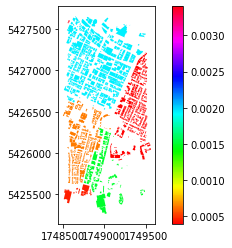

In [25]:
%%time
# load data
gdf_polygon = load_data("buildings_raw.shp", 1748570, 5425500, 1749500, 5427600) # small
# gdf_polygon = load_data("buildings_raw.shp", 1748000, 5424148, 1750000, 5427600) # larger
# gdf_polygon = load_data("buildings_raw.shp", 1740508, 5420049, 1755776, 5443033) # whole
gdf_polygon.plot(column='IgnProb_bl', cmap='hsv', legend=True)

In [26]:
%%time
# create edge list and network
E = edge_list_itertuple(gdf_polygon, 45)

# create edges
G = create_network(E)

# plot network
options = {'node_color': 'black', 'node_size': 20, 'width': 1, 'alpha': 0.4,
               'with_labels': False, 'font_weight': 'bold'}
nx.draw_kamada_kawai(G, **options)

number of dataframe loaded : 1 / 1611 total
number of dataframe loaded : 2 / 1611 total
number of dataframe loaded : 3 / 1611 total
number of dataframe loaded : 4 / 1611 total
number of dataframe loaded : 5 / 1611 total
number of dataframe loaded : 6 / 1611 total
number of dataframe loaded : 7 / 1611 total
number of dataframe loaded : 8 / 1611 total
number of dataframe loaded : 9 / 1611 total
number of dataframe loaded : 10 / 1611 total
number of dataframe loaded : 11 / 1611 total
number of dataframe loaded : 12 / 1611 total
number of dataframe loaded : 13 / 1611 total
number of dataframe loaded : 14 / 1611 total
number of dataframe loaded : 15 / 1611 total
number of dataframe loaded : 16 / 1611 total
number of dataframe loaded : 17 / 1611 total
number of dataframe loaded : 18 / 1611 total
number of dataframe loaded : 19 / 1611 total
number of dataframe loaded : 20 / 1611 total
number of dataframe loaded : 21 / 1611 total
number of dataframe loaded : 22 / 1611 total
number of dataframe

NameError: ignored

In [0]:
%%time
# run model
scos, burns = main(100, E)

In [0]:
%%time
# generate output
count_gdf = postprocessing(scenarios_recorded=scos, burned_asset=burns, gdf_polygons=gdf_polygon)

In [0]:
%%time
# check convergence
from itertools import groupby
number_of_burns_per_scenarios = [len(list(group)) for key, group in groupby(scos)]
cumulative_number_of_burns_per_scenarios = list(np.cumsum(number_of_burns_per_scenarios))
scenario_list = list(set(scos))
scenario_list = [x+1 for x in scenario_list]

average_burn_per_scenario = [c / s for c,s in zip(cumulative_number_of_burns_per_scenarios, scenario_list)]

In [0]:
plt.plot(scenario_list, average_burn_per_scenario)